# Marginal 1-dim posteriors from image data

- Using SWYFT core functions
- Demonstrates `head` network

Author: Christoph Weniger, July 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
DEVICE = 'cuda:0'
NDIM = 5 # number of parameters
NBATCH = 128  # minibatch size
NTRAIN = 3000
NEPOCHS = NTRAIN // (NTRAIN // NBATCH) # training epochs
NSAMPLES = 3000 # traing batch size
NWORKERS = 4 # number of cpu workers for dataloader

# Simulator

Given parameters $a, b, c, d, e$ we write the simulator as a sum of functions of position and functions of random variables. The checker pattern is defined 

$$ a \cos(x + 2 b) \cos(y + 2 c). $$

Given $n \sim \mathcal{N}(-0.3, 1)$, the point source random variable is a function of $n$ such that

$$ d \, 10^{e n}. $$

With another noise random variable $noise \sim \mathcal{N}(0, 0.1)$, finally the image in full is

$$ 5 a \cos(x + 2 b) \cos(y + 2 c) + d \, 10^{e n} + noise .$$

In [3]:
# A toy model with a diffuse and point source component

def model(z, sigma = .1):
    z = z.numpy()
    x = np.linspace(-5, 5, 50, 50)
    X, Y = np.meshgrid(x,x)
    diff = np.cos(X+z[1]*2)*np.cos(Y+z[2]*2)*z[0]
    p = np.random.randn(*X.shape)*z[4]-0.3
    psc = 10**p*z[3]
    n = np.random.randn(*X.shape)*sigma
    out = (diff*5 + psc + n)
    return torch.tensor(out).float()

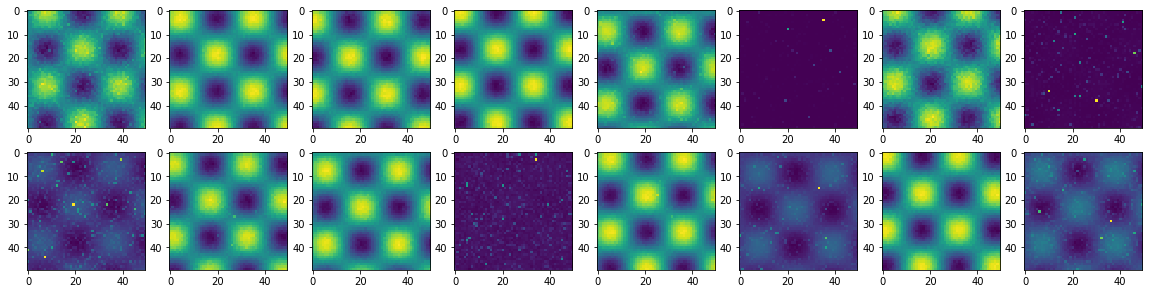

In [4]:
# Random image realizations

plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    z0 = torch.rand(5)
    x0 = model(z0)
    plt.imshow(x0.numpy())

In [5]:
class Data(torch.utils.data.Dataset):
    def __init__(self, xz):
        super().__init__()
        self.xz = xz

    def __len__(self):
        return len(self.xz)

    def __getitem__(self, idx):
        return self.xz[idx]

In [6]:
# Generate training data
z_cpu = swyft.sample_hypercube(NSAMPLES, NDIM)
xz_cpu = swyft.simulate_xz(model, z_cpu)

xz = Data(xz_cpu)
xz_loader = torch.utils.data.DataLoader(xz, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)

# batch_sampler = torch.utils.data.BatchSampler(
#     torch.utils.data.RandomSampler(xz, replacement=True, num_samples=NTRAIN * NBATCH),
#     batch_size=NBATCH,
#     drop_last=True
# )
# xz_loader = torch.utils.data.DataLoader(xz, batch_sampler=batch_sampler, num_workers=NWORKERS, pin_memory=True)

In [7]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 20, 5)
        self.conv3 = torch.nn.Conv2d(20, 40, 5)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

In [8]:
# Get number of features by evaluating Head network once on target data

ydim = Head()(x0.unsqueeze(0)).shape[1]  # Number of output features per image
print("Number of features:", ydim)

Number of features: 160


In [9]:
# Instantiate network

net = swyft.Network(xdim = ydim, zdim = NDIM, head = Head().to(DEVICE)).to(DEVICE)

In [10]:
# Train!

loss  = swyft.train(net, xz_loader, n_epochs = NEPOCHS, lr = 1e-3, device=DEVICE)
loss += swyft.train(net, xz_loader, n_epochs = NEPOCHS, lr = 1e-4, device=DEVICE)
loss += swyft.train(net, xz_loader, n_epochs = NEPOCHS, lr = 1e-5, device=DEVICE)

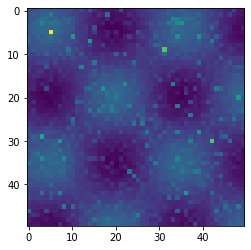

In [11]:
# Generate test image for given parameters, estimate posteriors

z0 = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5])
x0 = model(z0)
plt.imshow(x0.numpy())

x0 = x0.to(DEVICE)
# z = [item.to(DEVICE) for item in swyft.get_z(xz)]
z = torch.stack(swyft.get_z(xz)).to(DEVICE)
post = swyft.estimate_lnL(net, x0, z)

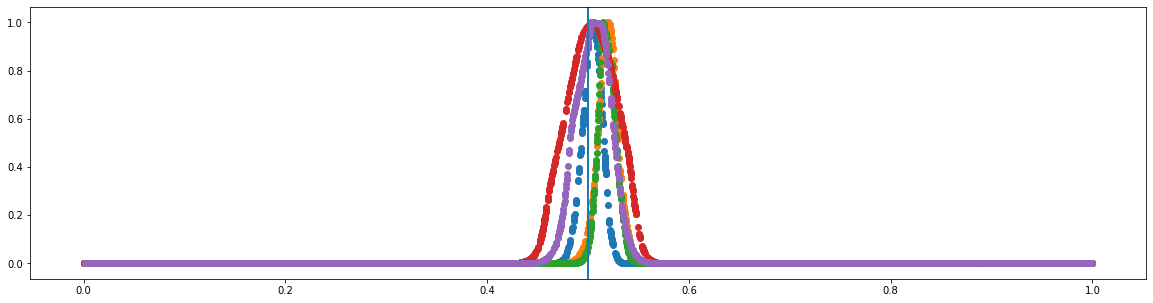

In [12]:
# Plot posteriors

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post[i]['z']
    lnLp = np.exp(post[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
#plt.ylim([-10, 0])

In [13]:
z2_cpu = swyft.iter_sample_z(NSAMPLES, NDIM, net, x0, threshold = 1e-10)
xz2_cpu = swyft.simulate_xz(model, z2_cpu)

xz2 = Data(xz2_cpu)
xz2_loader = torch.utils.data.DataLoader(xz2, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)
# batch_sampler = torch.utils.data.BatchSampler(
#     torch.utils.data.RandomSampler(xz2, replacement=True, num_samples=NTRAIN * NBATCH),
#     batch_size=NBATCH,
#     drop_last=True
# )
# xz2_loader = torch.utils.data.DataLoader(xz2, batch_sampler=batch_sampler, num_workers=NWORKERS, pin_memory=True)

In [14]:
# Instantiate network

net2 = swyft.Network(xdim = ydim, zdim = NDIM, head = Head().to(DEVICE)).to(DEVICE).train()
loss  = swyft.train(net2, xz2_loader, n_epochs = NEPOCHS, lr = 1e-3, device = DEVICE)
loss += swyft.train(net2, xz2_loader, n_epochs = NEPOCHS, lr = 1e-4, device = DEVICE)
loss += swyft.train(net2, xz2_loader, n_epochs = NEPOCHS, lr = 1e-5, device = DEVICE)

(0, 1)

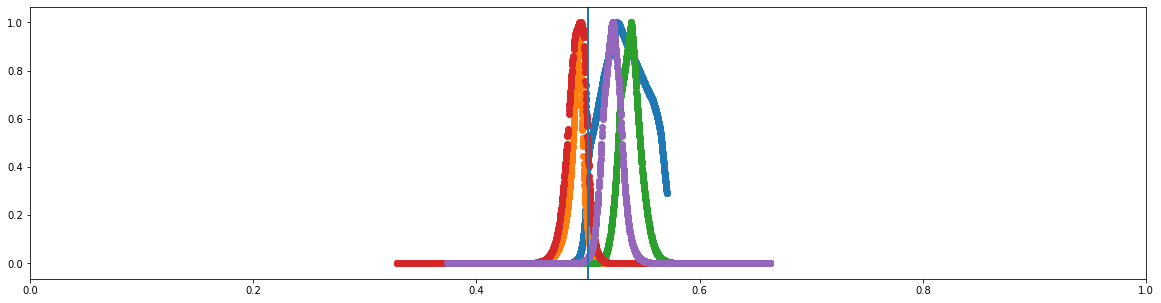

In [15]:
z2 = [item.to(DEVICE) for item in swyft.get_z(xz2)]
post2 = swyft.estimate_lnL(net2, x0, z2)

plt.figure(figsize=(20, 5))
for i in range(NDIM):
    zp = post2[i]['z']
    lnLp = np.exp(post2[i]['lnL'])
    plt.axvline(z0[i])
    plt.scatter(zp, lnLp)
plt.xlim([0, 1])

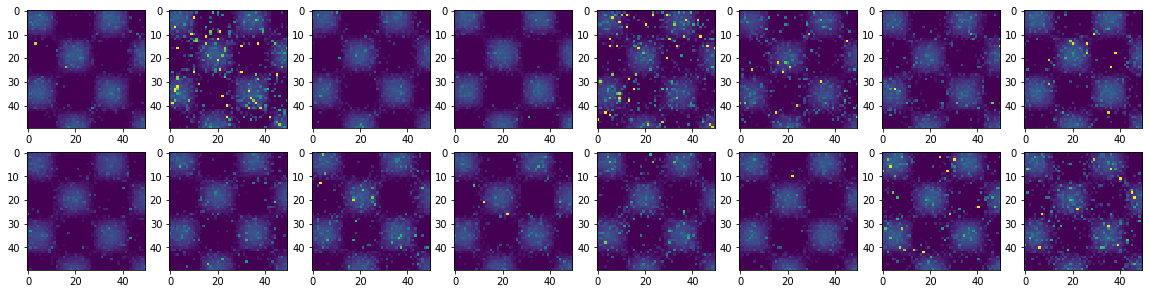

In [16]:
plt.figure(figsize=(20, 10))
for i in range(16):
    plt.subplot(4, 8, i+1)
    plt.imshow(model(z2[i].cpu()).numpy(), vmin = 0, vmax = 10)